# ROC Analysis LDA

## Data Generation
* Fix a beta* value and number of predictors
* Create a Y vector using Bernoulli distribution for logit
* Create a X vector using normal distribution as i.i.ds

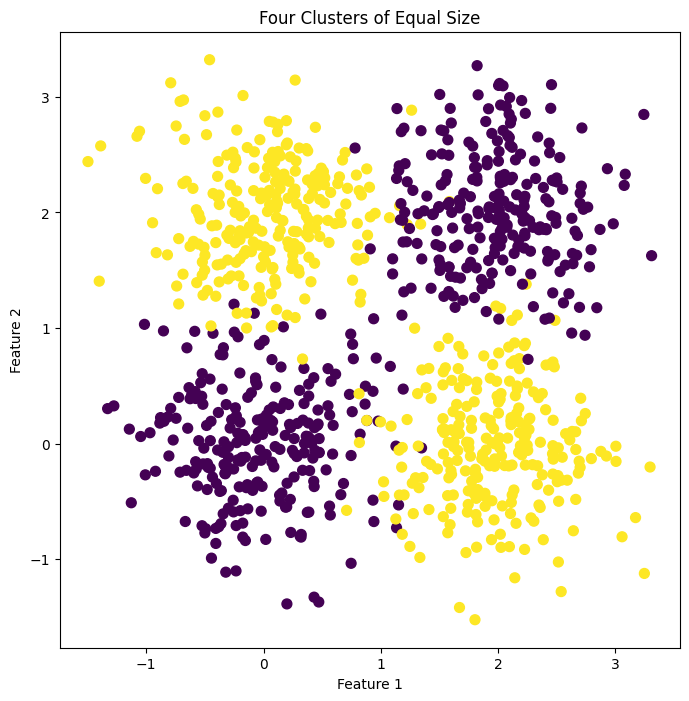

Training data shape: (800, 2), (800,)
Test data shape: (200, 2), (200,)


In [1]:
no_predictors = 2
no_samples = 1000
no_classes = 2
kerneltype = 'linear'  #comment out for polynomial kernel
#kerneltype = 'poly'  #comment out for linear kernel

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

n_samples_per_cluster = 250
n_clusters = 4

# Create the clusters deterministically
np.random.seed(0) # for reproducibility

X = np.zeros((n_samples_per_cluster * n_clusters, 2))
y = np.zeros(n_samples_per_cluster * n_clusters)

# Cluster centers in corners of a square
centers = [[0, 0], [2, 0], [0, 2], [2, 2]]

# Assign points to clusters deterministically
for i in range(n_clusters):
    cluster_indices = slice(i * n_samples_per_cluster, (i + 1) * n_samples_per_cluster)
    X[cluster_indices] = centers[i] + np.random.normal(scale=0.5, size=(n_samples_per_cluster, 2))
    if i == 0 or i == 3:
        y[cluster_indices] = 0
    else:
        y[cluster_indices] = 1



#Visualize
plt.figure(figsize=(8,8))
plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50)
plt.title('Four Clusters of Equal Size')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

#add intercept to X
#X = np.hstack((np.ones((X.shape[0], 1)), X))

# # shuffle data
# permutation = np.random.permutation(no_samples)
# X = X[permutation]
# y = y[permutation]


#Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Test data shape: {X_test.shape}, {y_test.shape}")





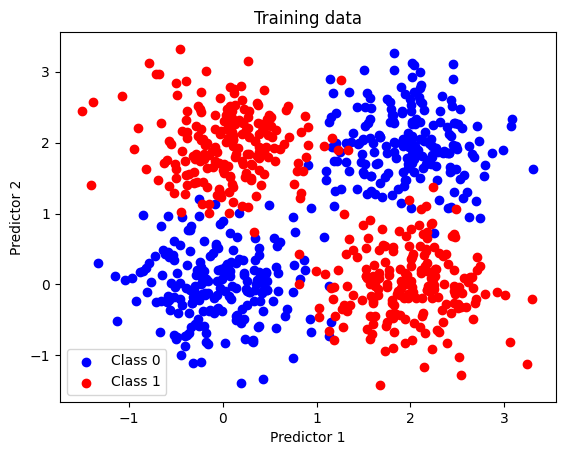

In [2]:
plt.figure()
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], color='b', label='Class 0') 
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], color='r', label='Class 1') 
plt.xlabel('Predictor 1') 
plt.ylabel('Predictor 2') 
plt.legend()
plt.title('Training data')
plt.show()

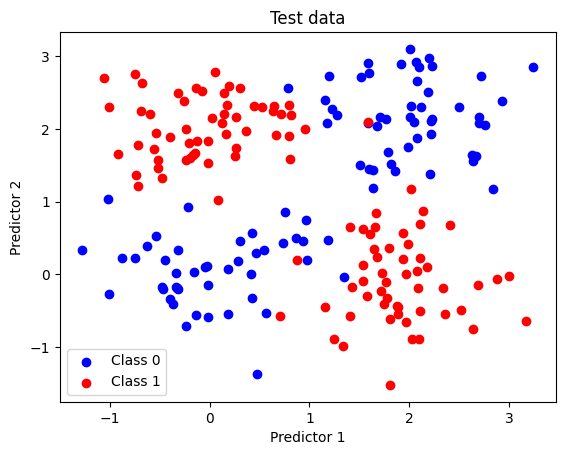

In [3]:
plt.figure()
plt.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], color='b', label='Class 0') 
plt.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], color='r', label='Class 1') 
plt.xlabel('Predictor 1') 
plt.ylabel('Predictor 2') 
plt.legend()
plt.title('Test data')
plt.show()

## Linear Discriminant Analysis Classifier

LDA assumes that all the class share the same covariance matrix

In [4]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)

LinearDiscriminantAnalysis()

In [5]:
beta_hat = clf.coef_[0] # w parameter in SVM
intercept = clf.intercept_[0] # b parameter in SVM
print('Estimated beta: ', beta_hat)
print('Intercept: ', intercept)

Estimated beta:  [0.06071938 0.00291889]
Intercept:  -0.09799004878894502


## Standard ROC curve

Length of threshold prc 200
Length of threshold_roc 102


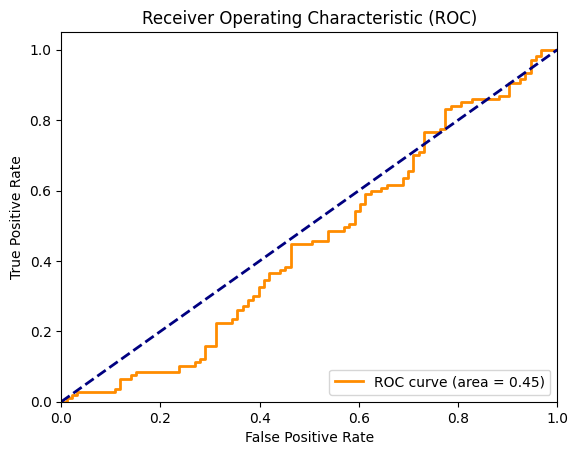

In [6]:
# Plot the RoC curve
from sklearn.metrics import roc_curve, precision_recall_curve, auc
fpr_roc, tpr_roc, threshold_roc = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
precision_prc, recall_prc, threshold_prc = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])

print("Length of threshold prc", len(threshold_prc))
print("Length of threshold_roc", len(threshold_roc))

roc_auc = auc(fpr_roc, tpr_roc)

# Plot the ROC curve
plt.figure()
plt.plot(fpr_roc, tpr_roc, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line representing random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

## Weighted ROC curve

In [8]:
import numpy as np
from sklearn.metrics import confusion_matrix

def get_fpr_tpr(clf_model, X_test, y_test):
    """
    Calculates the False Positive Rate (FPR) and True Positive Rate (TPR) at a given threshold.

    Args:
        X_test: The test features.
        y_test: The true test labels (0 or 1).
        threshold: The probability threshold.

    Returns:
        A dictionary containing the FPR and TPR. Returns None if there's an error.
    """
    try:
        y_pred = clf_model.predict(X_test) # predict directly

        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  #Avoid division by zero
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0 #Avoid division by zero
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        misclassification_rate = 1 - accuracy

        return {"fpr": fpr, "tpr": tpr, "precision": precision, "recall": recall, "f1": f1, "accuracy": accuracy, "misclassification_rate": misclassification_rate}

    except ValueError as e:
        print(f"Error calculating FPR and TPR: {e}")
        return None


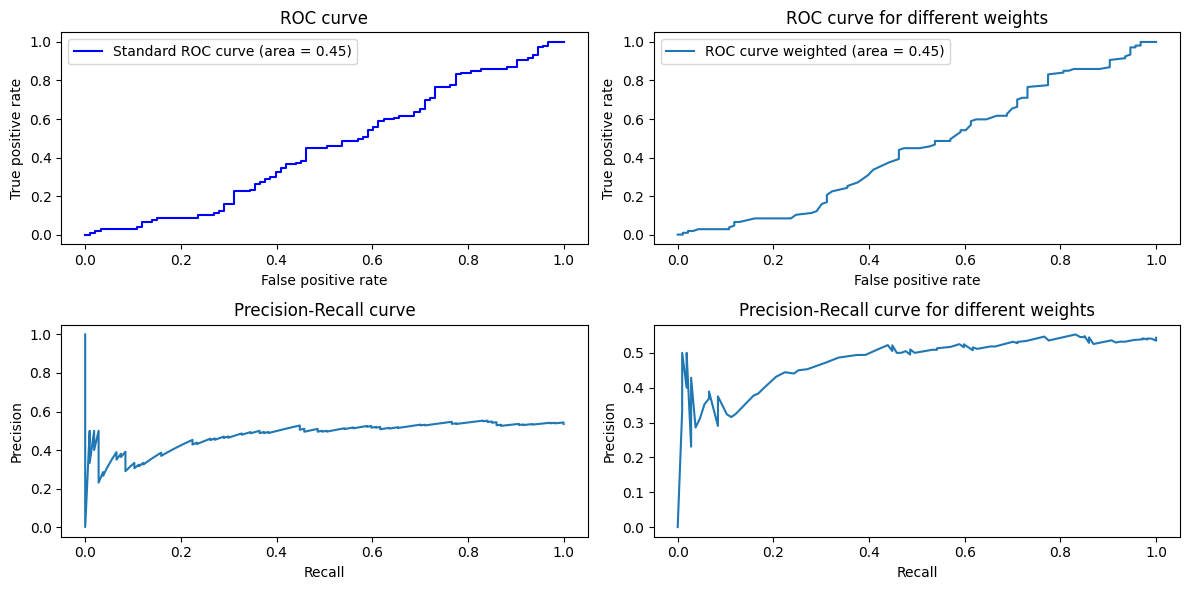

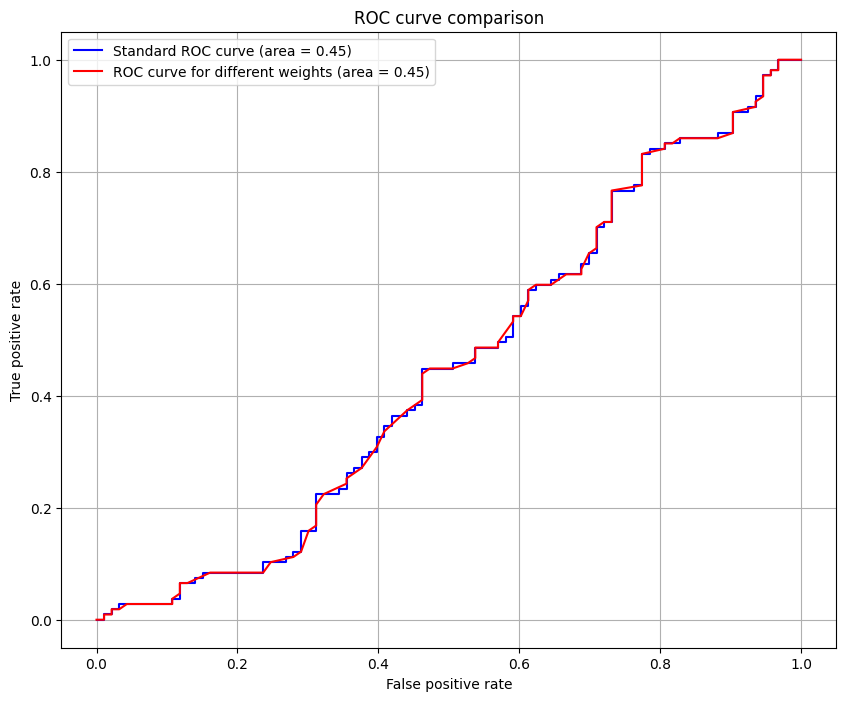

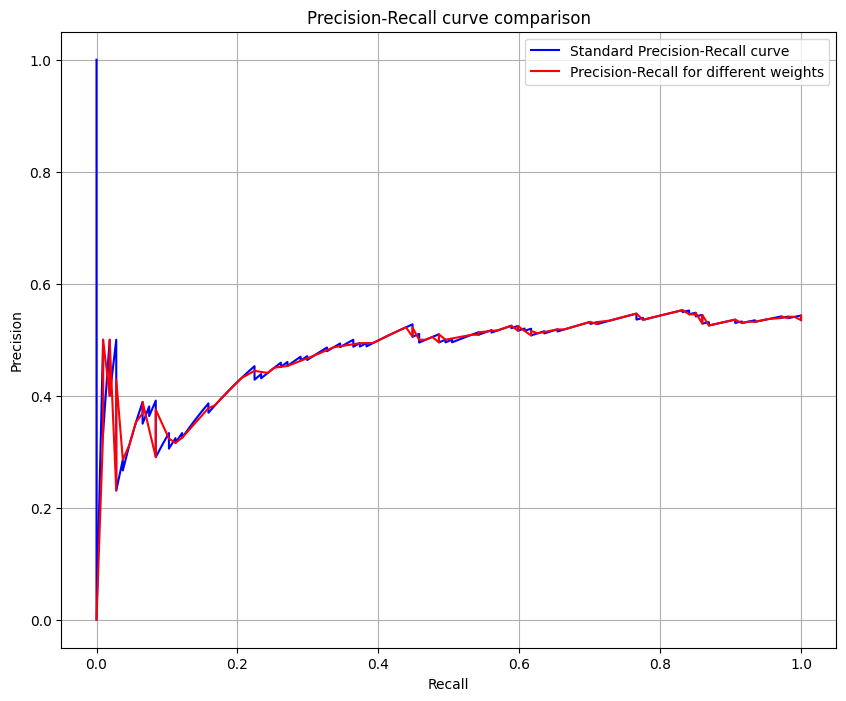

In [9]:
# Weight the X_train and y_train for cost-sensitive learning
minority_class_weight = np.arange(0.001, 0.999, 0.0005)
majority_class_weight = 1.0 - minority_class_weight
dict_weighted_clfs = {}
for w in minority_class_weight:
    #class_weights = {0: 1 - w, 1: w}
    priors_array = [1-w,w]
    clf_weighted = LinearDiscriminantAnalysis(priors=priors_array)
    clf_weighted.fit(X_train, y_train)

    res = get_fpr_tpr(clf_weighted, X_test, y_test)
    dict_weighted_clfs[w] = {
        "model": clf_weighted,
        "fpr": res["fpr"],
        "tpr": res["tpr"],
        "precision": res["precision"],
        "recall": res["recall"],
        "f1": res["f1"],
        "accuracy": res["accuracy"],
        "misclassification_rate": res["misclassification_rate"]
    }
    #print(f"Weight: {w:.2f}, FPR: {res['fpr']:.3f}, TPR: {res['tpr']:.3f}")

# Extract and sort FPR and TPR values from the weighted classifiers
fpr_weighted = [v["fpr"] for v in dict_weighted_clfs.values()]
tpr_weighted = [v["tpr"] for v in dict_weighted_clfs.values()]
roc_points = sorted(zip(fpr_weighted, tpr_weighted))
fpr_weighted_sorted = [p[0] for p in roc_points]
tpr_weighted_sorted = [p[1] for p in roc_points]

# Calculate AUC for weighted ROC curve
roc_auc_weighted = auc(fpr_weighted_sorted, tpr_weighted_sorted)

# Plot the FPR vs TPR for the different weights
fig,ax = plt.subplots(2, 2, figsize=(12, 6))
ax[0][0].plot(fpr_roc, tpr_roc, label=f'Standard ROC curve (area = {roc_auc:.2f})', color='blue')
ax[0][0].set_xlabel('False positive rate')
ax[0][0].set_ylabel('True positive rate')
ax[0][0].set_title('ROC curve')
ax[0][0].legend()
ax[0][1].plot(fpr_weighted_sorted, tpr_weighted_sorted, label=f'ROC curve weighted (area = {roc_auc_weighted:.2f})')
ax[0][1].set_xlabel('False positive rate')
ax[0][1].set_ylabel('True positive rate')
ax[0][1].set_title('ROC curve for different weights')
ax[0][1].legend()
ax[1][0].plot(recall_prc, precision_prc)
ax[1][0].set_xlabel('Recall')
ax[1][0].set_ylabel('Precision')
ax[1][0].set_title('Precision-Recall curve')

# Extract and sort precision-recall values
recall_weighted = [v["recall"] for v in dict_weighted_clfs.values()]
precision_weighted = [v["precision"] for v in dict_weighted_clfs.values()]
pr_points = sorted(zip(recall_weighted, precision_weighted))
recall_weighted_sorted = [p[0] for p in pr_points]
precision_weighted_sorted = [p[1] for p in pr_points]

ax[1][1].plot(recall_weighted_sorted, precision_weighted_sorted)
ax[1][1].set_xlabel('Recall')
ax[1][1].set_ylabel('Precision')
ax[1][1].set_title('Precision-Recall curve for different weights')
plt.tight_layout()
plt.show()

# Plot both ROC curves on the same plot figure
plt.figure(figsize=(10, 8))
plt.plot(fpr_roc, tpr_roc, label=f'Standard ROC curve (area = {roc_auc:.2f})', color='blue')
plt.plot(fpr_weighted_sorted, tpr_weighted_sorted, label=f'ROC curve for different weights (area = {roc_auc_weighted:.2f})', color='red')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.title('ROC curve comparison')
plt.grid(True)
plt.show()

# Plot both Precision-Recall curves on the same plot figure
plt.figure(figsize=(10, 8))
plt.plot(recall_prc, precision_prc, label='Standard Precision-Recall curve', color='blue')
plt.plot(recall_weighted_sorted, precision_weighted_sorted, label='Precision-Recall for different weights', color='red')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision-Recall curve comparison')
plt.grid(True)
plt.show()

LDA does not do a good job in discriminating the 2 classes. This is simply because the data of the 2 classes do not have the same covariance matrices. The RED class has a negative covariance (High covariate 2 for low covariate 1 and vice versa), while the BLUE class has a positive covariance (low covariate 2 for low covariate 1 and vice versa). So we will use Quadratic discriminant analysis instead.

In [10]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
clf = QuadraticDiscriminantAnalysis()
clf.fit(X_train, y_train)

QuadraticDiscriminantAnalysis()

Length of threshold prc 200
Length of threshold_roc 20


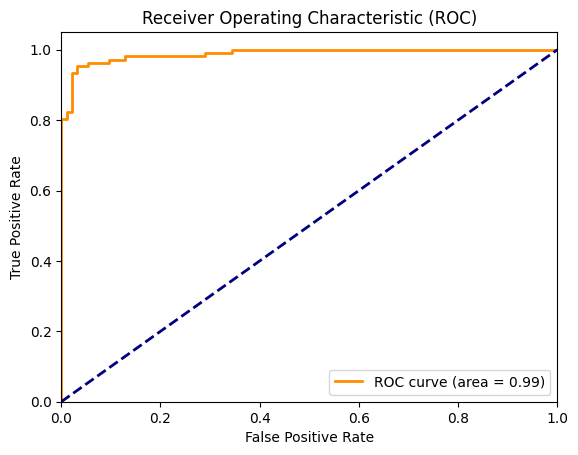

In [11]:
# Plot the RoC curve
from sklearn.metrics import roc_curve, precision_recall_curve, auc
fpr_roc, tpr_roc, threshold_roc = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
precision_prc, recall_prc, threshold_prc = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])

print("Length of threshold prc", len(threshold_prc))
print("Length of threshold_roc", len(threshold_roc))

roc_auc = auc(fpr_roc, tpr_roc)

# Plot the ROC curve
plt.figure()
plt.plot(fpr_roc, tpr_roc, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line representing random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:976: RuntimeWarning: divide by zero encountered in log
  return -0.5 * (norm2 + u) + np.log(self.priors_)


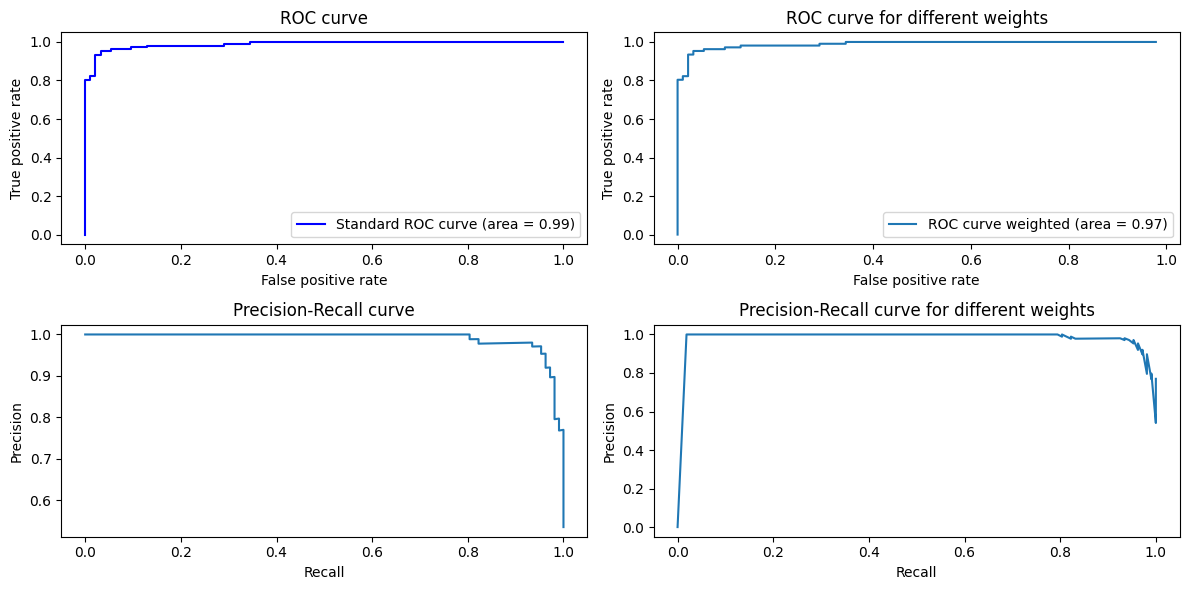

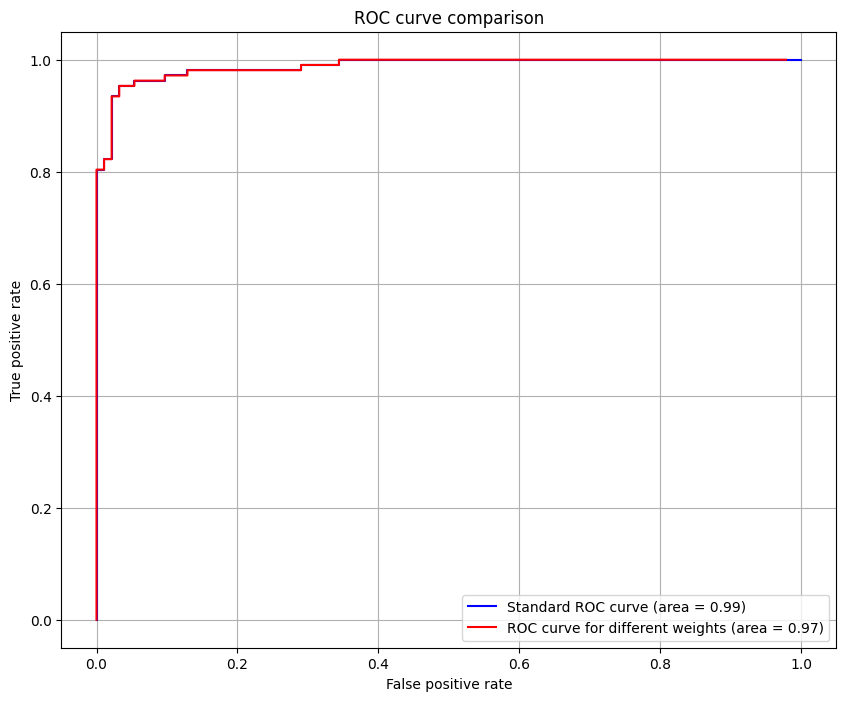

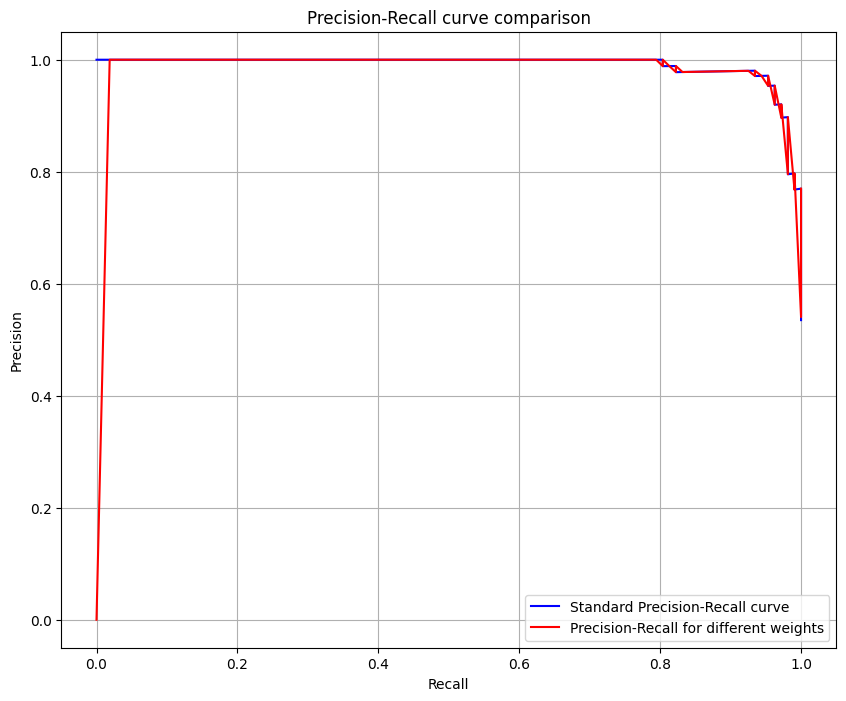

In [15]:
# Weight the X_train and y_train for cost-sensitive learning
minority_class_weight = np.arange(0, 1, 0.00001)
majority_class_weight = 1.0 - minority_class_weight
dict_weighted_clfs = {}
for w in minority_class_weight:
    #class_weights = {0: 1 - w, 1: w}
    priors_array = [1-w,w]
    clf_weighted = QuadraticDiscriminantAnalysis(priors=priors_array)
    clf_weighted.fit(X_train, y_train)

    res = get_fpr_tpr(clf_weighted, X_test, y_test)
    dict_weighted_clfs[w] = {
        "model": clf_weighted,
        "fpr": res["fpr"],
        "tpr": res["tpr"],
        "precision": res["precision"],
        "recall": res["recall"],
        "f1": res["f1"],
        "accuracy": res["accuracy"],
        "misclassification_rate": res["misclassification_rate"]
    }
    #print(f"Weight: {w:.2f}, FPR: {res['fpr']:.3f}, TPR: {res['tpr']:.3f}")

# Extract and sort FPR and TPR values from the weighted classifiers
fpr_weighted = [v["fpr"] for v in dict_weighted_clfs.values()]
tpr_weighted = [v["tpr"] for v in dict_weighted_clfs.values()]
roc_points = sorted(zip(fpr_weighted, tpr_weighted))
fpr_weighted_sorted = [p[0] for p in roc_points]
tpr_weighted_sorted = [p[1] for p in roc_points]

# Calculate AUC for weighted ROC curve
roc_auc_weighted = auc(fpr_weighted_sorted, tpr_weighted_sorted)

# Plot the FPR vs TPR for the different weights
fig,ax = plt.subplots(2, 2, figsize=(12, 6))
ax[0][0].plot(fpr_roc, tpr_roc, label=f'Standard ROC curve (area = {roc_auc:.2f})', color='blue')
ax[0][0].set_xlabel('False positive rate')
ax[0][0].set_ylabel('True positive rate')
ax[0][0].set_title('ROC curve')
ax[0][0].legend()
ax[0][1].plot(fpr_weighted_sorted, tpr_weighted_sorted, label=f'ROC curve weighted (area = {roc_auc_weighted:.2f})')
ax[0][1].set_xlabel('False positive rate')
ax[0][1].set_ylabel('True positive rate')
ax[0][1].set_title('ROC curve for different weights')
ax[0][1].legend()
ax[1][0].plot(recall_prc, precision_prc)
ax[1][0].set_xlabel('Recall')
ax[1][0].set_ylabel('Precision')
ax[1][0].set_title('Precision-Recall curve')

# Extract and sort precision-recall values
recall_weighted = [v["recall"] for v in dict_weighted_clfs.values()]
precision_weighted = [v["precision"] for v in dict_weighted_clfs.values()]
pr_points = sorted(zip(recall_weighted, precision_weighted))
recall_weighted_sorted = [p[0] for p in pr_points]
precision_weighted_sorted = [p[1] for p in pr_points]

ax[1][1].plot(recall_weighted_sorted, precision_weighted_sorted)
ax[1][1].set_xlabel('Recall')
ax[1][1].set_ylabel('Precision')
ax[1][1].set_title('Precision-Recall curve for different weights')
plt.tight_layout()
plt.show()

# Plot both ROC curves on the same plot figure
plt.figure(figsize=(10, 8))
plt.plot(fpr_roc, tpr_roc, label=f'Standard ROC curve (area = {roc_auc:.2f})', color='blue')
plt.plot(fpr_weighted_sorted, tpr_weighted_sorted, label=f'ROC curve for different weights (area = {roc_auc_weighted:.2f})', color='red')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.title('ROC curve comparison')
plt.grid(True)
plt.show()

# Plot both Precision-Recall curves on the same plot figure
plt.figure(figsize=(10, 8))
plt.plot(recall_prc, precision_prc, label='Standard Precision-Recall curve', color='blue')
plt.plot(recall_weighted_sorted, precision_weighted_sorted, label='Precision-Recall for different weights', color='red')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision-Recall curve comparison')
plt.grid(True)
plt.show()

## Weighted RoC curve using resampling

In [ ]:
# Weight the X_train and y_train for cost-sensitive learning
minority_class_weight = np.arange(0, 1, 0.00001)
majority_class_weight = 1.0 - minority_class_weight
dict_weighted_clfs = {}
for w in minority_class_weight:
    #class_weights = {0: 1 - w, 1: w}
    priors_array = [1-w,w]
    clf_weighted = QuadraticDiscriminantAnalysis(priors=priors_array)
    clf_weighted.fit(X_train, y_train)

    res = get_fpr_tpr(clf_weighted, X_test, y_test)
    dict_weighted_clfs[w] = {
        "model": clf_weighted,
        "fpr": res["fpr"],
        "tpr": res["tpr"],
        "precision": res["precision"],
        "recall": res["recall"],
        "f1": res["f1"],
        "accuracy": res["accuracy"],
        "misclassification_rate": res["misclassification_rate"]
    }
    #print(f"Weight: {w:.2f}, FPR: {res['fpr']:.3f}, TPR: {res['tpr']:.3f}")

# Extract and sort FPR and TPR values from the weighted classifiers
fpr_weighted = [v["fpr"] for v in dict_weighted_clfs.values()]
tpr_weighted = [v["tpr"] for v in dict_weighted_clfs.values()]
roc_points = sorted(zip(fpr_weighted, tpr_weighted))
fpr_weighted_sorted = [p[0] for p in roc_points]
tpr_weighted_sorted = [p[1] for p in roc_points]

# Calculate AUC for weighted ROC curve
roc_auc_weighted = auc(fpr_weighted_sorted, tpr_weighted_sorted)

# Plot the FPR vs TPR for the different weights
fig,ax = plt.subplots(2, 2, figsize=(12, 6))
ax[0][0].plot(fpr_roc, tpr_roc, label=f'Standard ROC curve (area = {roc_auc:.2f})', color='blue')
ax[0][0].set_xlabel('False positive rate')
ax[0][0].set_ylabel('True positive rate')
ax[0][0].set_title('ROC curve')
ax[0][0].legend()
ax[0][1].plot(fpr_weighted_sorted, tpr_weighted_sorted, label=f'ROC curve weighted (area = {roc_auc_weighted:.2f})')
ax[0][1].set_xlabel('False positive rate')
ax[0][1].set_ylabel('True positive rate')
ax[0][1].set_title('ROC curve for different weights')
ax[0][1].legend()
ax[1][0].plot(recall_prc, precision_prc)
ax[1][0].set_xlabel('Recall')
ax[1][0].set_ylabel('Precision')
ax[1][0].set_title('Precision-Recall curve')

# Extract and sort precision-recall values
recall_weighted = [v["recall"] for v in dict_weighted_clfs.values()]
precision_weighted = [v["precision"] for v in dict_weighted_clfs.values()]
pr_points = sorted(zip(recall_weighted, precision_weighted))
recall_weighted_sorted = [p[0] for p in pr_points]
precision_weighted_sorted = [p[1] for p in pr_points]

ax[1][1].plot(recall_weighted_sorted, precision_weighted_sorted)
ax[1][1].set_xlabel('Recall')
ax[1][1].set_ylabel('Precision')
ax[1][1].set_title('Precision-Recall curve for different weights')
plt.tight_layout()
plt.show()

# Plot both ROC curves on the same plot figure
plt.figure(figsize=(10, 8))
plt.plot(fpr_roc, tpr_roc, label=f'Standard ROC curve (area = {roc_auc:.2f})', color='blue')
plt.plot(fpr_weighted_sorted, tpr_weighted_sorted, label=f'ROC curve for different weights (area = {roc_auc_weighted:.2f})', color='red')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.title('ROC curve comparison')
plt.grid(True)
plt.show()

# Plot both Precision-Recall curves on the same plot figure
plt.figure(figsize=(10, 8))
plt.plot(recall_prc, precision_prc, label='Standard Precision-Recall curve', color='blue')
plt.plot(recall_weighted_sorted, precision_weighted_sorted, label='Precision-Recall for different weights', color='red')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision-Recall curve comparison')
plt.grid(True)
plt.show()